# Read in the data

In [30]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [31]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [32]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [33]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets for only the 2011-2012 School Year

In [34]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [35]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [36]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [37]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [38]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

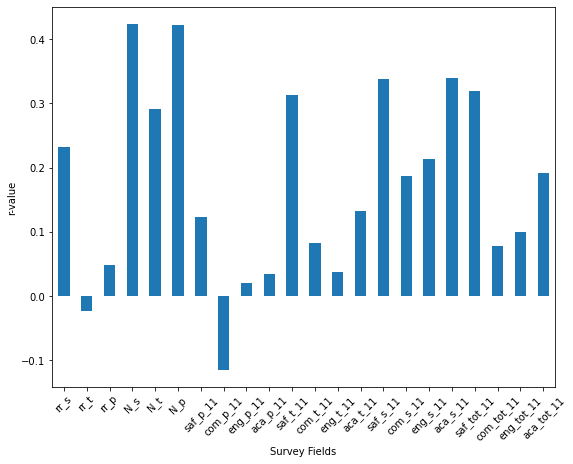

In [39]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
import matplotlib.pylab as plt
correlations = correlations[survey_fields]
plt.figure(figsize=(9,7))
correlations.plot.bar(rot = 45)
plt.ylabel("r-value")
plt.xlabel("Survey Fields")
plt.show()

# Insights on some correlations
Looking at the most survey field with the most negative correlation, which is saf_p_11 (Safety and Respect score) seems to show that having a higher score of that tends to have lower sat scores from that school, albeit the strength of the r-value is very weak. The strongest r-values coem from N_s and N_p (number of student and parent respondents). This seems to show that schools that have more students respondents tend to have  higher sat scores, which makes sense since you are more likely to respond this type of survey if you're doing well academically.  

# Plotting saf_s_11 VS. Sat Scores

[]

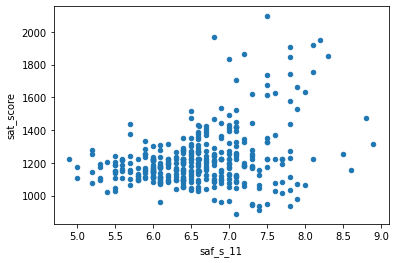

In [40]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')
plt.plot()

# Scatter findings
From above, we can see the positive trend of higher SAT scores as the students preception of school safety goes up.

In [41]:
average_safety_score = combined.groupby('boro')['saf_s_11'].mean()
print(average_safety_score)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


[]

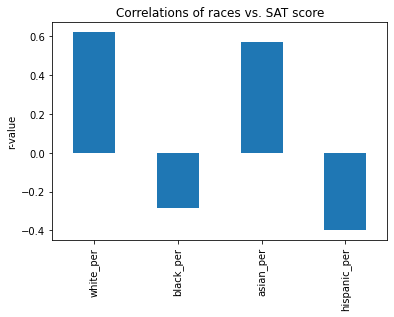

In [42]:
races = ["white_per", "black_per", "asian_per", "hispanic_per"]
correlations = combined.corr()["sat_score"][races]
correlations.plot.bar()
plt.ylabel("r-value")
plt.title("Correlations of races vs. SAT score")
plt.plot()

[]

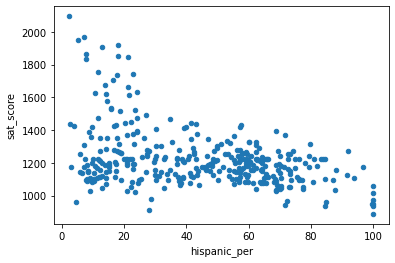

In [43]:
combined.plot.scatter(x = "hispanic_per", y = "sat_score")
plt.plot()

[]

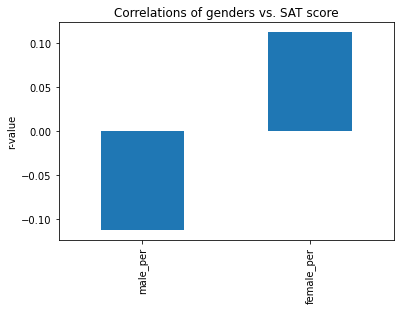

In [44]:
genders = ["male_per", "female_per"]
correlations = combined.corr()["sat_score"][genders]
correlations.plot.bar()
plt.ylabel("r-value")
plt.title("Correlations of genders vs. SAT score")
plt.plot()

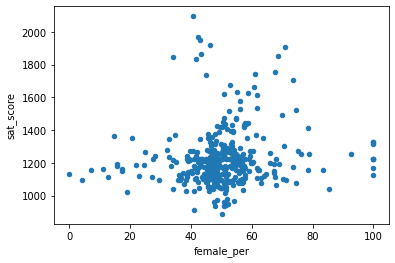

In [45]:
combined.plot.scatter(x = "female_per", y = "sat_score")
plt.show()

In [46]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["school_name"]

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.



0.05717081390766952


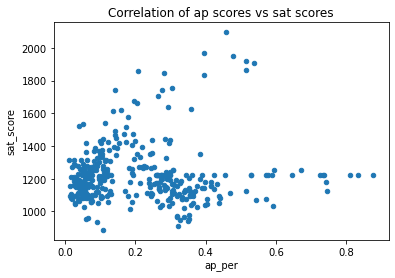

In [53]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x = "ap_per" , y = "sat_score")
print(combined.corr()["ap_per"]["sat_score"])
plt.title("Correlation of ap scores vs sat scores")
plt.show()

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.